<a href="https://colab.research.google.com/github/madhavgn007/Photos2Sketch_Sketch2Photo/blob/main/src/S2P/CUHK_S2P_ConvAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import numpy as np
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input

In [ ]:
def sorted_alphanumeric(data):
    """Sort list of strings alphanumerically"""
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data, key=alphanum_key)

def preprocess_image(img_path, size):
    """Load, resize, normalize, and augment image"""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (size, size))
    img_normalized = img_resized / 255.0
    return img_normalized

def augment_image(img):
    """Flip and rotate image"""
    flipped_img = cv2.flip(img, 1)
    img_vert_flip = cv2.rotate(img, cv2.ROTATE_180)
    flipped_img_vert_flip = cv2.rotate(flipped_img, cv2.ROTATE_180)
    img_right = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    flipped_img_right = cv2.rotate(flipped_img, cv2.ROTATE_90_CLOCKWISE)
    img_left = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    flipped_img_left = cv2.rotate(flipped_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return [img, flipped_img, img_vert_flip, flipped_img_vert_flip, img_right, flipped_img_right, img_left, flipped_img_left]

# Define the directory where the images are located
photos = "../../data/raw/CUHK_training_cropped_photos/"
sketches = "../../data/raw/CUHK_training_cropped_sketches/"

# Define the image size
SIZE = 256

# Load and preprocess photos and sketches
photo_files = sorted_alphanumeric(os.listdir(photos))
sketch_files = sorted_alphanumeric(os.listdir(sketches))

X_train = []
y_train = []
for pf, sf in zip(photo_files, sketch_files):
    # Load and augment photo
    photo_path = os.path.join(photos, pf)
    photo_aug = augment_image(preprocess_image(photo_path, SIZE))
    # Load and augment sketch
    sketch_path = os.path.join(sketches, sf)
    sketch_aug = augment_image(preprocess_image(sketch_path, SIZE))
    # Combine photo and sketch augmentations
    for i, j in zip(photo_aug, sketch_aug):
        X_train.append(i)
        y_train.append(j)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Split into train and test sets
n_train = 1400
X_test = X_train[n_train:]
y_test = y_train[n_train:]
X_train = X_train[:n_train]
y_train = y_train[:n_train]

In [ ]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU())
    return upsample

def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 3, False)(encoder_input)
    x = downsample(32,3)(x)
    x = downsample(64,3, False)(x)
    x = downsample(128,3)(x)
    x = downsample(256,3)(x)

    encoder_output = downsample(512,3)(x)

    decoder_input = upsample(512,3,True)(encoder_output)

    x = upsample(256,3)(decoder_input)
    x = upsample(128,3, True)(x)
    x = upsample(64,3)(x)
    x = upsample(32,3)(x)
    x = tf.keras.layers.Conv2DTranspose(16,(3, 3),strides = (2,2), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2, 2),strides = (1,1), padding = 'valid')(x)
    return tf.keras.Model(encoder_input, decoder_output)

In [ ]:
# to get summary of model
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 127, 127, 16)      432       
                                                                 
 sequential_1 (Sequential)   (None, 63, 63, 32)        4736      
                                                                 
 sequential_2 (Sequential)   (None, 31, 31, 64)        18432     
                                                                 
 sequential_3 (Sequential)   (None, 15, 15, 128)       74240     
                                                                 
 sequential_4 (Sequential)   (None, 7, 7, 256)         295936    
                                                                 
 sequential_5 (Sequential)   (None, 3, 3, 512)         118169

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = "mean_absolute_error", metrics=['acc'])

history = model.fit(y_train, X_train, epochs=100, validation_data=(y_test, X_test))

Epoch 1/100
44/44 [==============================] - 16s 49ms/step - loss: 0.2497 - acc: 0.2958 - val_loss: 3.9109 - val_acc: 0.3816
Epoch 2/100
44/44 [==============================] - 1s 32ms/step - loss: 0.1326 - acc: 0.7206 - val_loss: 0.6191 - val_acc: 0.4411
Epoch 3/100
44/44 [==============================] - 1s 31ms/step - loss: 0.1206 - acc: 0.8036 - val_loss: 0.2063 - val_acc: 0.5130
Epoch 4/100
44/44 [==============================] - 1s 31ms/step - loss: 0.1077 - acc: 0.8286 - val_loss: 0.1886 - val_acc: 0.8172
Epoch 5/100
44/44 [==============================] - 1s 32ms/step - loss: 0.1040 - acc: 0.8396 - val_loss: 0.1220 - val_acc: 0.8332
Epoch 6/100
44/44 [==============================] - 1s 31ms/step - loss: 0.0986 - acc: 0.8517 - val_loss: 0.1630 - val_acc: 0.7524
Epoch 7/100
44/44 [==============================] - 1s 32ms/step - loss: 0.0946 - acc: 0.8597 - val_loss: 0.1242 - val_acc: 0.8867
Epoch 8/100
44/44 [==============================] - 1s 31ms/step - loss: 0

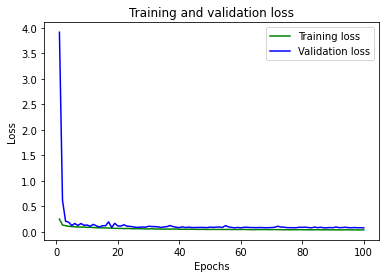

In [ ]:
# Plot loss curves
train_loss = history.history['loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(y_test, X_test)

4/4 [==============================] - 0s 16ms/step - loss: 0.0781 - acc: 0.9124


[0.07806503027677536, 0.912403404712677]

In [ ]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,2,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,2,2)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

1/1 [==============================] - 0s 23ms/step


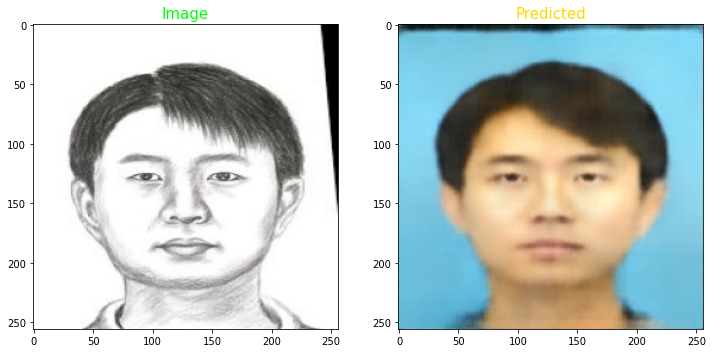

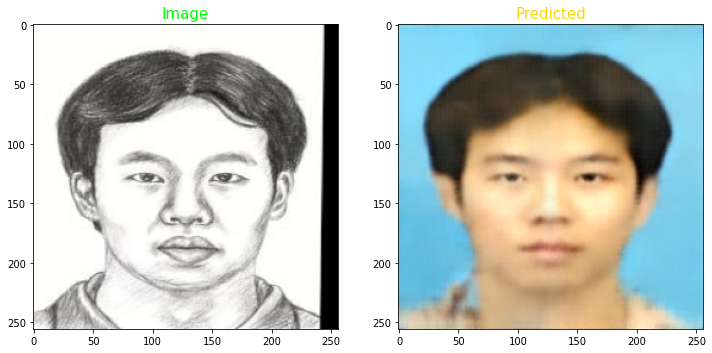

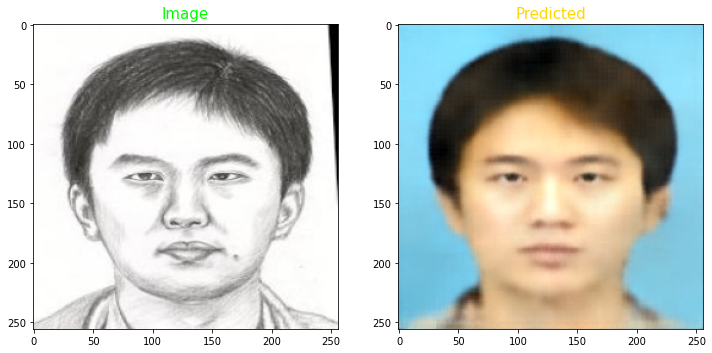

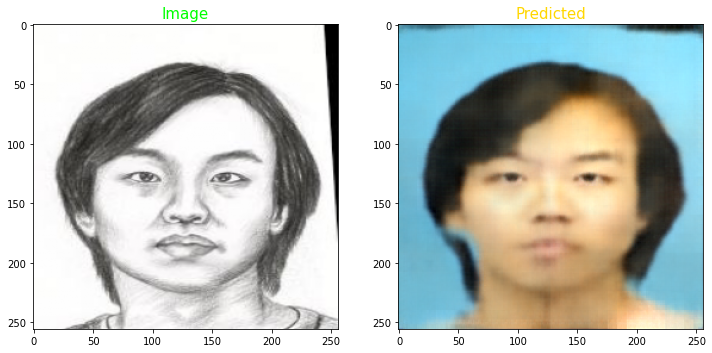

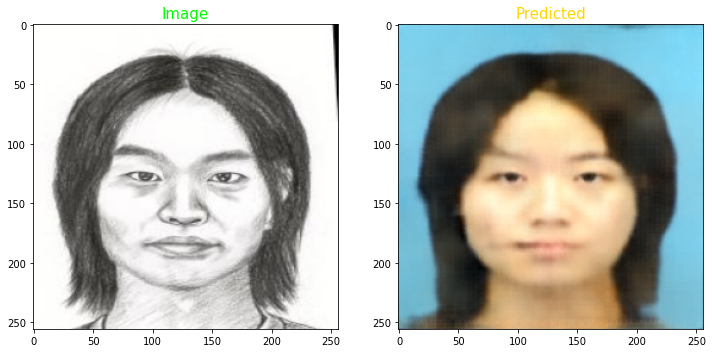

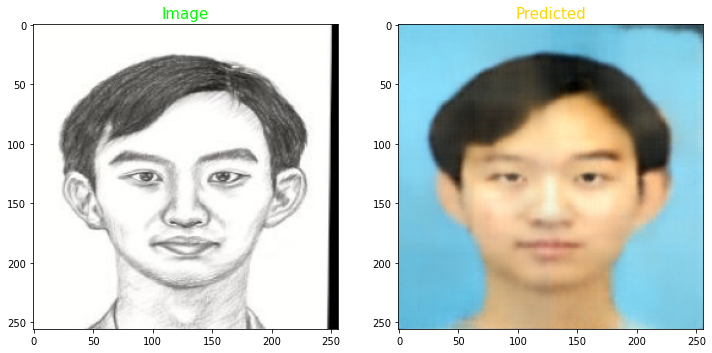

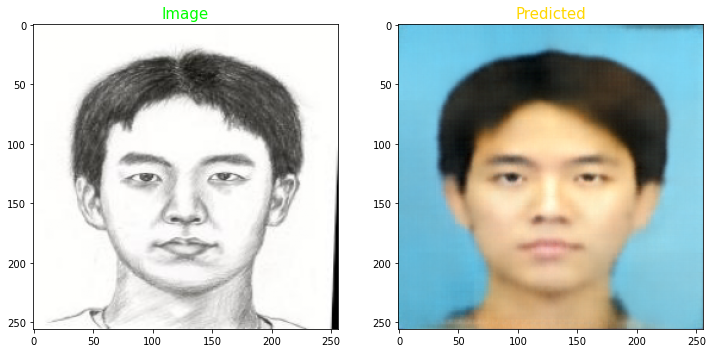

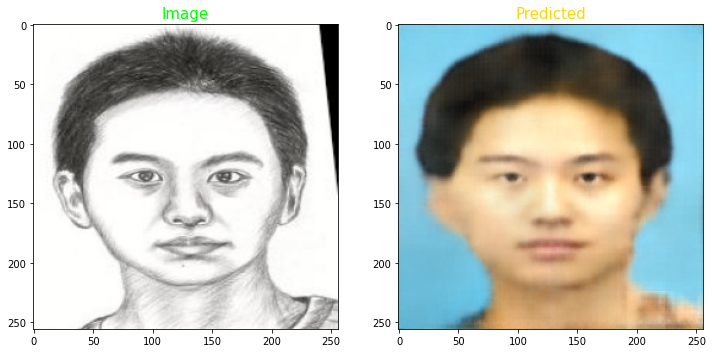

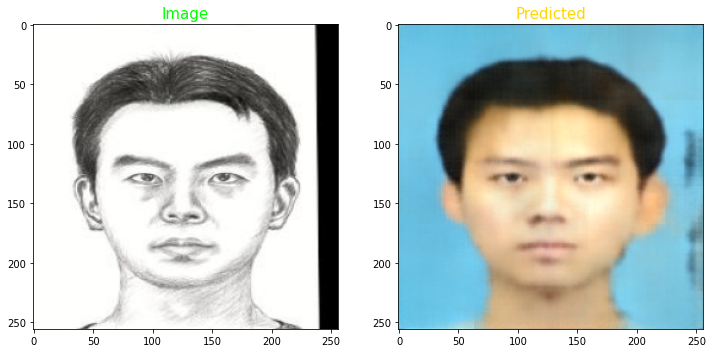

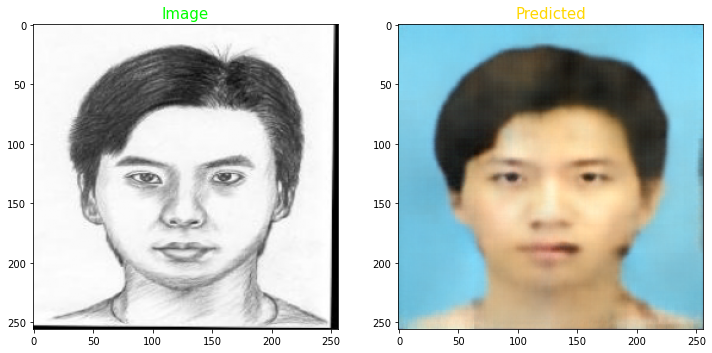

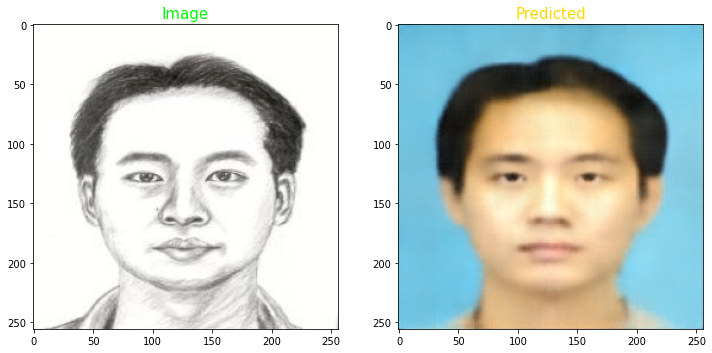

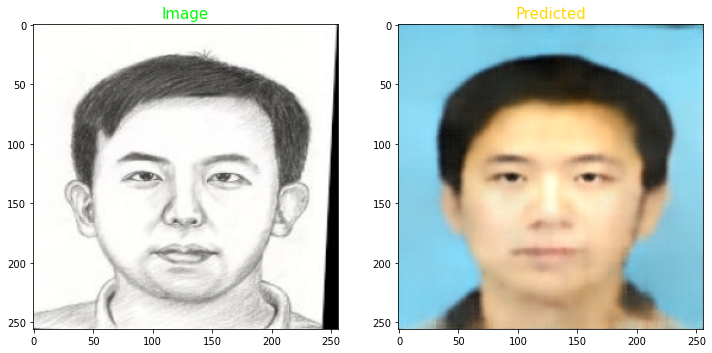

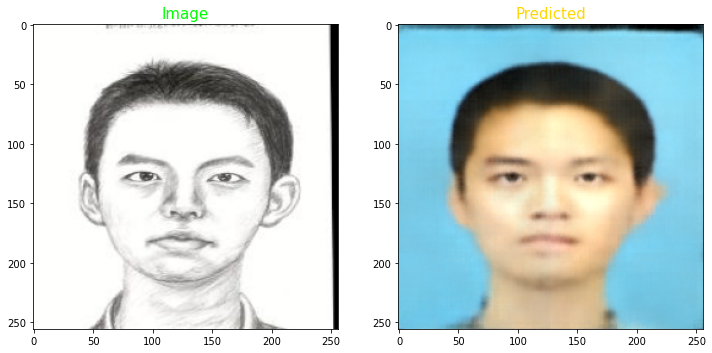

In [ ]:
for i in np.arange(0, 100, 8):
    predicted =np.clip(model.predict(y_test[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(y_test[i],X_test[i],predicted)

In [ ]:
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.metrics import mean_squared_error
import numpy as np

# Generate facial sketches using the autoencoder on test set
predicted = model.predict(y_test)

# Calculate mean squared error between predicted and ground truth sketches
mse = mean_squared_error(X_test.flatten(), predicted.flatten())

# Calculate SSIM score for each generated sketch compared to the ground truth
ssim_scores = [compare_ssim(X_test[i], predicted[i], multichannel=True) for i in range(len(predicted))]

# Calculate the average SSIM score
avg_ssim_score = np.mean(ssim_scores)

print("Average SSIM score:", avg_ssim_score)
print("RMSE score:", np.sqrt(mse))

4/4 [==============================] - 0s 10ms/step


<ipython-input-10-e546e6453b8c>:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_scores = [compare_ssim(X_test[i], predicted[i], multichannel=True) for i in range(len(predicted))]
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Average SSIM score: 0.8257966187539874
RMSE score: 0.1239797591934704
